# Sentiment Analysis through User Navigation Paths (Wikispeedia)
**Goal**: To explore the relationship between semantic change and emotional fluctuation throughout human navigation paths.

**Pipeline**: 
1. **Experiment with Text Embeddings and Distance Measures:** Use various text embeddings (e.g., Word2Vec) and distance measures (such as Cosine Similarity) to calculate differences between embeddings, representing semantic distance at each step in each navigation path. Apply clustering to select the optimal semantic distance measure for this analysis, prioritizing the measure that results in minimal clustering bias as our semantic distance indicator.

2. **Define and Calculate Emotion Scores:** Use a benchmarked emotion prediction model to generate emotion scores, which output 26 types of emotion scores (see reference: ...). Our approach considers human attention span and cognitive aspects of reading behavior:

   * Users pay more attention to hyperlinks during navigation than to plain text.
   * Attention increases when hyperlinks are more relevant to the target.
   * Attention decays as reading progresses down the page, correlating with increasing reading sparsity.

   Based on these observations, we reweight the emotion annotations from the pretrained model accordingly (see Section X of the notebook).

3. **Analyze Semantic Distance and Emotion Scores for Correlation:**

   * We performed an initial test to verify some degree of correlation between semantic distance and emotion scores.
   * In the next phase, we will explore deeper relationships (correlation, causality, or induction) between each type of emotion and textual semantic change.
   * We aim to determine if certain semantic jumps (over α% distance change) induce specific types of emotions.


**Potential Applications of Findings:**

   * Predict readers' emotional responses by structuring semantic changes between articles.
   * Enhance emotional impact to increase an article’s popularity.
   * Explore additional future applications.

## 1. Optimal Semantic Distance

## 2. Attention Oriented Emotion Labeling

### 2.1. HTML Content Preprocessing and Extraction with Hyperlink Preservation

This part we first extracts semantic segments from HTML files of all webpages, and define and calculate weighted emotion scores based on human reading attentioen on hyperlink and increasing sparsity.

We considered the action of \
•	Lemmatization: Reduces words to their base form (e.g., “running” to “run”). \
•	Stemming: Trims words to their root (e.g., “jumps” to “jump”).

Benefits of Lemmatization and Stemming in Sentiment Analysis

1.	Both lemmatization and stemming reduce words to a common form, which can help models by reducing vocabulary size and focusing on the base meaning of words. For instance, “amazing” and “amazingly” become “amaz,” which may help a simpler model recognize these as similar in sentiment.
2.	Reducing Noise: Variations in verb tenses or plural forms don’t usually impact sentiment. By simplifying “running,” “ran,” and “runs” to “run,” the model can better focus on the emotional content of the words rather than linguistic variations.

Drawbacks of Lemmatization and Stemming

1.	Loss of Nuance: Stemming, in particular, can lead to words losing critical distinctions. For example, “happy” and “happiness” might both be stemmed to “happi,” which removes any slight difference in meaning or intensity that could be relevant to sentiment.
2.	Complicated Sentiment Contexts: Certain suffixes can carry sentiment information. For instance, “help” (neutral) versus “helpful” (positive). Stemming might remove these subtle distinctions, potentially reducing accuracy.

However, for transformer models (e.g., BERT, RoBERTa) or when working with models trained on large datasets, as these models already account for nuanced variations. Modern models handle token variations well, and stemming can reduce performance by discarding subtle context. Therefore, lemmatization alone might be a safer choice than stemming. It preserves word meaning more accurately, while still standardizing some forms. Stemming might only be beneficial for smaller, less nuanced datasets where word reduction is crucial.

Hence, we only perform lemmatization here.

Extracts readable text from HTML content while preserving hyperlinks. The anchor tags in the HTML content will be converted to a format that includes the anchor text and URL in the form `[anchor_text](URL)`. The function splits the text into sentences to make it more aligned with natural reading behavior.

In [1]:
from src.emotion.emotion_utils import preprocess_text, extract_text_from_html, extract_sentences, generate_link_freq_dict, extract_path_data
from src.emotion.emotion_scores import calculate_weighted_emotion_for_single_path, process_backtracking_paths
from src.emotion.emotion_visualization import plot_link_frequencies

[nltk_data] Downloading package punkt to /Users/fht/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/fht/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/fht/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
extract_sentences('data/original_dataset/wpcd/wp').head(3)

/Users/fht/Desktop/ada/project/ada-2024-project-tada2024/src/emotion/emotion_utils.py:92: DtypeWarning: Columns (490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,721,722,723,724,725,726,727,728,729,730
0,Royal_Marines.htm,Royal Marines Royal Marines [ 2007 Schools Wik...,Related subject : [ Military History and War ]...,A core component of the country 's Rapid Deplo...,"The high level of training and competence , co...",The Royal Marines are a component part of the ...,Role Corps of Royal Marines Cap Badge of the R...,As the United Kingdom Armed Forces ' specialis...,In common with the other armed force the Royal...,"Command , Control and Organisation Command of ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Recycling.htm,Recycling Recycling [ 2007 Schools Wikipedia S...,Related subject : [ Environment ] ( URL ) [ ] ...,[ Environmental science ] ( URL ) Environmenta...,Recycling prevents useful material resource be...,Recycling is a key concept of modern [ waste m...,"Recyclable material , also called `` recyclabl...","They include [ glass ] ( URL ) , paper , [ alu...","Biodegradable waste , such a food waste or gar...",Recyclates need to be sorted and separated int...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Retreat_of_glaciers_since_1850.htm,Retreat of glacier since 1850 Retreat of glaci...,Related subject : [ Climate and the Weather ] ...,"Studied by glaciologists , the temporal coinci...",Mid-latitude mountain range such a the [ Himal...,The Little Ice Age wa a period from about 1550...,"Subsequently , until about 1940 glacier around...","Glacial retreat slowed and even reversed , in ...","However , since 1980 a significant global warm...",In location such a the Andes of [ South Americ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2.2. Attention Span Weight Calculation

#### 2.2.1. Link Attention Modelling

First we will generate a dictionary the contains the count of each linked link corresponding with each target.

Reasoning:
> To model human attention in navigation, we hypothesize that a human navigator is likely to focus more on links or titles that are relevant to their end goal, or target article. By examining real human behavioral data, we can derive a dictionary that quantifies the frequency of articles encountered on the way to each target article. This dictionary serves as an indicator of the correlation between each intermediate link/title and the target article.

> This correlation relationship gives insight into a human's inclination to choose specific links or titles based on their relevance to the target. In other words, the more frequently an article appears in paths leading to a particular target, the more likely it reflects a natural inclination or preference in human navigation behavior. The unclicked links will share the same ambigutious / preassumed inclination.

In [3]:
generate_link_freq_dict('data/original_dataset/wikispeedia_paths-and-graph/paths_finished.tsv')

{'African_slave_trade': {'14th_century': 2,'Europe': 3,'Africa': 16,'Atlantic_slave_trade': 18, ......}


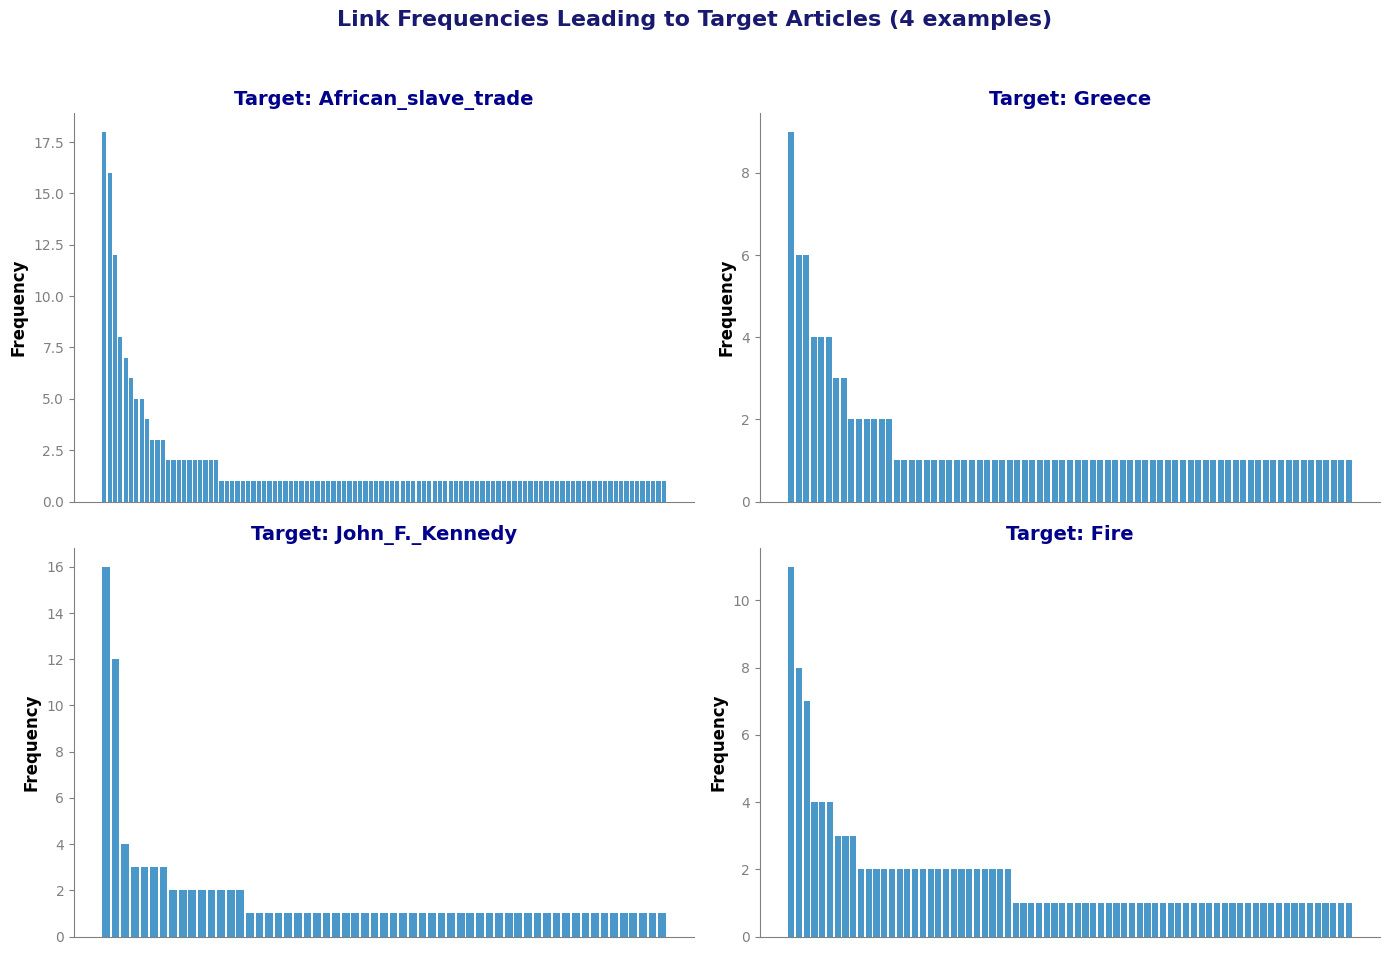

In [4]:
plot_link_frequencies('data/emotion/link_freq_dict.json')

Exponential Distribution of Frequencies: 
 
In each target’s subplot, the frequencies of articles leading to the target display an exponential-like property: a small number of articles have high frequencies, while most other articles appear less frequently. This indicates that users tend to follow a few common paths when navigating to a target, suggesting a strong preference for specific links that are likely perceived as highly relevant to the end goal.

#### 2.2.2. Sentence Weight Assignment

To model user attention, we assume that users are more likely to focus on links within sentences, as these links serve as potential pathways to reach their target. Therefore, sentences containing links (`[ anchor_text ] ( URL )`) are assigned relatively higher weights than those without links, which share a baseline weight.

In addition, we use link click frequency as an indicator of the attention drawn by each link. Links that have been clicked more frequently are likely to be perceived as more relevant or interesting, indicating a higher level of attention from users. Consequently, the weight for each link is proportional to its click frequency, and links with higher click frequencies are assigned greater weights than those with no recorded clicks.

The weight assignment method is formalised as following:

> Mathematical Expression for Sentence Weight Assignment

To model sentence weight based on link presence and click frequency, we define the following:

1. Let $S$ be a sentence.
2. Let $L_i$ represent each link in sentence $S$, where $i = 1, 2, \ldots, n$ (if there are $n$ links in the sentence).
3. Let $f(L_i)$ denote the click frequency of link $L_i$.
4. Let $W_{baseline}$ represent the baseline weight assigned to sentences with no links.

> Weight Assignment Formula

The weight $W(S)$ for sentence $S$ is assigned as follows:

1. **If $S$ contains no links**, assign a baseline weight:
   $$
   W(S) = W_{\text{baseline}}
   $$

2. **If $S$ contains links**, the weight of $S$ is calculated based on a normalized sum of the click frequencies for the links in $S$:
   $$
   W(S) = W_{\text{baseline}} + k \cdot \sum_{i=1}^n \frac{f(L_i)}{\text{\#links for target}}
   $$
   where:
   - $W_{\text{baseline}}$ is the baseline weight for sentences without links.
   - $k$ is a proportionality constant that scales the contribution of click frequency to the overall sentence weight.
   - $f(L_i)$ represents the click frequency of link $L_i$.
   - $\text{\#links for target}$ is the total sum of click frequencies for all links leading to the specified target.


> Explanation of the Formula

- **Baseline Weight $W_{\text{baseline}}$**: Ensures that every sentence has a minimum weight, even if it contains no links.
- **Click Frequency Contribution**: The term $\sum_{i=1}^n k \cdot f(L_i)$ increases the weight for sentences containing links based on how frequently those links are clicked. The higher the frequency $f(L_i)$ for a link, the greater the weight for the sentence, reflecting increased user attention.
- **Normalization Term $\frac{f(L_i)}{\text{\#links for target}}$**: Each link’s frequency $f(L_i)$ is divided by the total click frequency for the target, ensuring that frequencies are comparable across targets with varying link counts.
- **Scaled Contribution**: The normalized click frequencies are scaled by $k$ and summed for each link in the sentence, providing an overall attention weight that reflects user focus based on link relevance and frequency.


This formula prioritizes sentences with high-frequency links, aligning with the assumption that frequently clicked links draw more user attention.

Relevant literature that justifies the choice above: 
> Kahneman, D. (1973). Attention and Effort. Prentice-Hall. This classic work emphasizes that attention is a limited resource and is selectively allocated to elements that are most informative or engaging.

Proportionality Constant ( $k$ ): This value ensures that while links with high click frequencies (popular or frequently chosen links) increase sentence weight significantly, the scaling remains moderate to reflect that human attention, even when selectively focused, tends to spread across multiple cues rather than concentrating exclusively on a single feature.

> Treisman, A. M., & Gelade, G. (1980). A feature-integration theory of attention. Cognitive Psychology, 12(1), 97-136. This study suggests that attention is directed based on feature saliency, but that it distributes across multiple features, particularly in complex tasks.

#### 2.2.3. Handling Backtracking in Path Analysis: Considerations for Emotional Analysis

In analyzing navigation paths, we must consider how to handle backtracking steps (represented by `<`). Backtracking occurs when users navigate back to a previous article, which can provide valuable insights into their exploratory behavior but may also introduce noise. Here, we explore two approaches: **removing backtracking** and **replacing backtracking with the previous article**. Each approach has unique implications for emotional analysis and the relationship between emotion change and semantic distance.

##### 1. Removing Backtracking
In this approach, all instances of `<` are removed from the path, resulting in a streamlined path sequence without backtracking steps.

**Pros**:
- **Cleaner Path Sequence**: Removing backtracking provides a straightforward path, showing only forward progression. This is beneficial when the focus is on direct associations between consecutive articles.
- **Simplified Emotional Analysis**: Without backtracking, emotional analysis can focus purely on the progression of emotions as users encounter new topics. This can make patterns in emotion change easier to identify and analyze.

**Cons**:
- **Loss of Exploration Behavior**: By removing backtracking, we lose information about the user’s exploratory behavior, which might be relevant to understanding emotional responses to content revisitation.
- **Potential Loss of Emotional Nuance**: Backtracking could indicate repeated exposure to emotionally charged topics. Without it, we might miss certain patterns in emotional reactions tied to revisiting previously encountered topics.

##### 2. Replacing Backtracking with the Previous Article
In this approach, each `<` is replaced with the last visited article, effectively duplicating articles in the path to indicate when users revisit content.

**Pros**:
- **Insight into Exploratory Patterns**: This approach preserves the user’s backtracking behavior, which may reveal exploratory or confirmatory patterns. These patterns could indicate deeper engagement with certain topics or themes.
- **Enhanced Emotional Analysis**: Repeated articles in the path allow us to track emotional responses to revisited content, which might reflect sustained or heightened emotions. For example, revisiting a topic with strong emotional content could amplify or stabilize the user’s emotional state.

**Cons**:
- **Increased Path Complexity**: Backtracking introduces additional steps in the path, which could complicate the analysis by increasing the number of steps and potentially diluting clear patterns in emotional progression.
- **Potential Noise in Emotional Trends**: If users frequently backtrack to neutral or less significant content, it could introduce noise in emotional trends, making it harder to distinguish meaningful emotional changes.

##### Relationship Between Emotion Change and Semantic Distance

The choice between removing or preserving backtracking also impacts the analysis of **emotion change in relation to semantic distance** between articles:
- **Removing Backtracking** emphasizes the semantic distance between new topics, allowing us to examine how emotional responses shift with each novel topic encountered.
- **Preserving Backtracking** captures both semantic proximity (revisiting the same topic) and changes over time, allowing for a more detailed study of how repeated exposure to specific content influences emotion.

By analyzing emotion change in conjunction with semantic distance, we can assess how users’ emotions evolve as they navigate through increasingly different (or similar) topics. This approach could reveal patterns such as emotional intensification with greater semantic distance or stabilization with repeated exposure.

In summary, each approach offers unique insights, and the best choice depends on the focus of the analysis:
- **Without Backtracking** is ideal for studying direct emotional progression across diverse topics.
- **With Backtracking** is suitable for understanding how emotional responses are influenced by topic revisitation and exploratory behavior.

In [5]:
path_df_no_backtracking = extract_path_data('dataset/wikispeedia_paths-and-graph/paths_finished.tsv', handle_backtracking='remove')
path_df_with_backtracking = extract_path_data('dataset/wikispeedia_paths-and-graph/paths_finished.tsv', handle_backtracking='replace')

Paths have been extracted and saved to dataset/extracted_paths_no_backtracking.csv
Paths have been extracted and saved to dataset/extracted_paths_with_backtracking.csv


#### 2.2.4. Weighted Emotion Scores

Now that each sentence has an associated emotion label, we can calculate a weighted emotion score for each sentence. This score combines the previously calculated attention weight of the sentence with its emotion label, providing a more nuanced view of the emotional significance based on user attention.

Let:
- $W(S)$ be the attention weight of sentence $S$, calculated as described previously.
- $E(S)$ be the emotion label (or emotion score) associated with sentence $S$.

The weighted emotion score for each sentence $S$ is calculated as:
$$
\text{E}_{weighted}(S) = W(S) \cdot E(S)
$$

This weighted emotion score provides a refined measure that accounts for both the emotional tone of the sentence and the likelihood that it will capture attention.

#### 2.2.5. Increasing Reading Sparsity: Nested Macro Average 

To account for the nature of reading sparsity, we will calculate a **Nested Macro Average** of weighted emotion scores by progressively grouping sentences. This approach reflects the likelihood that readers pay more attention to earlier sentences and progressively less to later sections.

##### Grouping Structure for Nested Macro Average

The weighted emotion scores are grouped as follows:
1. The first sentence alone: $[1]$
2. The second and third sentences together: $[2, 3]$
3. The fourth, fifth, and sixth sentences together: $[4, 5, 6]$
4. The seventh through tenth sentences together: $[7, 8, 9, 10]$
5. Continue grouping in this nested manner, with each subsequent group containing one additional sentence.

##### Steps for Calculating the Nested Macro Average

1. **Calculate the Weighted Emotion for Each Group**: For each group, calculate the average weighted emotion score within the group.
   
2. **Average the Grouped Scores**: After calculating the average for each group, take the average of these grouped scores to obtain the final Nested Macro Average.


Let:
- $W\_E(S_i)$ represent the weighted emotion score of sentence $S_i$.
- Groups are defined as $G_1 = [S_1]$, $G_2 = [S_2, S_3]$, $G_3 = [S_4, S_5, S_6]$, $G_4 = [S_7, S_8, S_9, S_{10}]$, and so forth, with each subsequent group expanding by one additional sentence.

The **Nested Macro Average** is calculated as:
$$
\text{Nested Macro Average} = \frac{1}{k} \sum_{j=1}^k \left( \frac{\sum_{i \in G_j} W\_E(S_i)}{|G_j|} \right)
$$
where:
- $k$ is the total number of groups,
- $G_j$ is the $j$-th group of sentences,
- $|G_j|$ is the number of sentences in group $G_j$,
- $\sum_{i \in G_j} W\_E(S_i)$ represents the sum of weighted emotions within group $G_j$.

This formula averages the weighted emotions within each group and then takes the overall average across groups. By weighting the earlier sentences more heavily, this approach provides a balanced measure that reflects both the emotional tone and the attentional distribution across the article.

In [6]:
import pandas as pd
import re
# Define file paths
unweighted_emotion = 'data/emotion/unweighted_emotion_article.csv'                 # Replace with the actual path for the first CSV
paths_nonbacktracking = 'data/emotion/extracted_paths_no_backtracking.csv' # Replace with the actual path for the no-backtracking CSV
paths_backtracking = 'data/emotion/extracted_paths_with_backtracking.csv' # Replace with the actual path for the backtracking CSV
click_frequencies = 'data/emotion/link_freq_dict.json' # Replace with the actual path for the click frequencies JSON
# Load the CSV files into DataFrames
unweighted_emotion = pd.read_csv(unweighted_emotion)
paths_backtracking = pd.read_csv(paths_backtracking)
paths_nonbacktracking = pd.read_csv(paths_nonbacktracking)
sentences = pd.read_csv('data/emotion/extracted_sentences.csv', index_col=0)
sentences.index = sentences.index.map(lambda x: re.split(r'\.html?$', str(x))[0] if isinstance(x, str) else x) # cases such as U.S._state.htm can be dealed correctly.

# Print index and headers for each DataFrame
print("DataFrame 1:")
print("Index:", unweighted_emotion.index)
print("Headers:", unweighted_emotion.columns.tolist(), "\n")

print("DataFrame 2 (No Backtracking):")
print("Index:", paths_backtracking.index)
print("Headers:", paths_backtracking.columns.tolist(), "\n")

print("DataFrame 3 (With Backtracking):")
print("Index:", paths_nonbacktracking.index)
print("Headers:", paths_nonbacktracking.columns.tolist(), "\n")

/var/folders/ww/0cs7zdg14jsc23xxm7ngz1fc0000gn/T/ipykernel_3738/2208799986.py:9: DtypeWarning: Columns (490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,

DataFrame 1:
Index: RangeIndex(start=0, stop=5462, step=1)
Headers: ['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146'

/var/folders/ww/0cs7zdg14jsc23xxm7ngz1fc0000gn/T/ipykernel_3738/2208799986.py:12: DtypeWarning: Columns (490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713

we have the emotion annotation (24 types) that consider both human attention span and reading sparsity for each article in each navigation path for each path. And here is an example for one path and one emotion.

In [7]:
# Test the function with a single path
first_row = paths_backtracking.iloc[0]
target = first_row['target']
path = first_row.drop(labels=['target']).dropna().tolist()

# Calculate the weighted emotions for this single path for the 'surprise' emotion
weighted_path_df = calculate_weighted_emotion_for_single_path(path, target, unweighted_emotion, sentences, click_frequencies, emotion_type='surprise')

print(weighted_path_df)

# Display the target and path
print("Target:", target)
print("Path:", path)

                target    Step_1    Step_2    Step_3    Step_4    Step_5  \
0  African_slave_trade  0.000339  0.000287  0.000306  0.000208  0.000251   

     Step_6    Step_7    Step_8  
0  0.000211  0.000292  0.000272  
Target: African_slave_trade
Path: ['14th_century', '15th_century', '16th_century', 'Pacific_Ocean', 'Atlantic_Ocean', 'Accra', 'Africa', 'Atlantic_slave_trade']


### 2.3 Result showcase

Now we can do the calculation through all emotions on all paths. And here we only consider backtracking paths. (We will do non-backtracking for milestone)
But for the milestone 2 we only proceed on two emotions: 'surprise' and 'curiosity' for our further discussion

In [8]:
process_backtracking_paths(paths_backtracking, unweighted_emotion, sentences, click_frequencies, emotion_type='surprise') # Emotion score on every step of every path, with backtracking on surprise emotion.
process_backtracking_paths(paths_backtracking, unweighted_emotion, sentences, click_frequencies, emotion_type='curiosity') # Emotion score on every step of every path, with backtracking on curiosity emotion.

Weighted emotions for each step in all paths have been calculated and saved to 'dataset/backtracking_path_weighted_emotions_surprise.csv'
Weighted emotions for each step in all paths have been calculated and saved to 'dataset/backtracking_path_weighted_emotions_curiosity.csv'


In [9]:
backtracking_path_weighted_emotions_surprise_df = pd.read_csv('data/emotion/backtracking_path_weighted_emotions_surprise.csv')
backtracking_path_weighted_emotions_curiosity_df = pd.read_csv('data/emotion/backtracking_path_weighted_emotions_curiosity.csv')
backtracking_path_weighted_emotions_surprise_df = backtracking_path_weighted_emotions_surprise_df.drop(columns=['path_index'])
backtracking_path_weighted_emotions_curiosity_df = backtracking_path_weighted_emotions_curiosity_df.drop(columns=['path_index'])

In [10]:
backtracking_path_weighted_emotions_surprise_df.head() # Display the DataFrame for surprise emotion

,target,Step_1,Step_2,Step_3,Step_4,Step_5,Step_6,Step_7,Step_8,Step_9,...,Step_425,Step_426,Step_427,Step_428,Step_429,Step_430,Step_431,Step_432,Step_433,Step_434
0,African_slave_trade,0.000339,0.000287,0.000306,0.000208,0.000251,0.000211,0.000292,0.000272,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,African_slave_trade,0.000339,0.000246,0.000292,0.000272,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,African_slave_trade,0.000339,0.000291,0.000337,0.000289,0.000186,0.000292,0.000272,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Greece,0.000339,0.000340,0.000444,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,John_F._Kennedy,0.000339,0.000317,0.000207,0.000355,0.000519,0.000233,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
backtracking_path_weighted_emotions_curiosity_df.head() # Display the DataFrame for curiosity emotion

,target,Step_1,Step_2,Step_3,Step_4,Step_5,Step_6,Step_7,Step_8,Step_9,...,Step_425,Step_426,Step_427,Step_428,Step_429,Step_430,Step_431,Step_432,Step_433,Step_434
0,African_slave_trade,0.000352,0.000296,0.000285,0.000333,0.000385,0.000250,0.000424,0.000651,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,African_slave_trade,0.000352,0.000489,0.000424,0.000651,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,African_slave_trade,0.000352,0.000311,0.000629,0.000245,0.000740,0.000424,0.000651,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Greece,0.000352,0.000881,0.000252,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,John_F._Kennedy,0.000352,0.000277,0.000401,0.001415,0.000479,0.000511,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Analyze Semantic Distance and Emotion Scores for Correlation

### 3.1. Emotion Scores with Steps

In [12]:
from src.emotion.emotion_visualization import plot_emotion_paths, calculate_emotion_correlation
import matplotlib.pyplot as plt

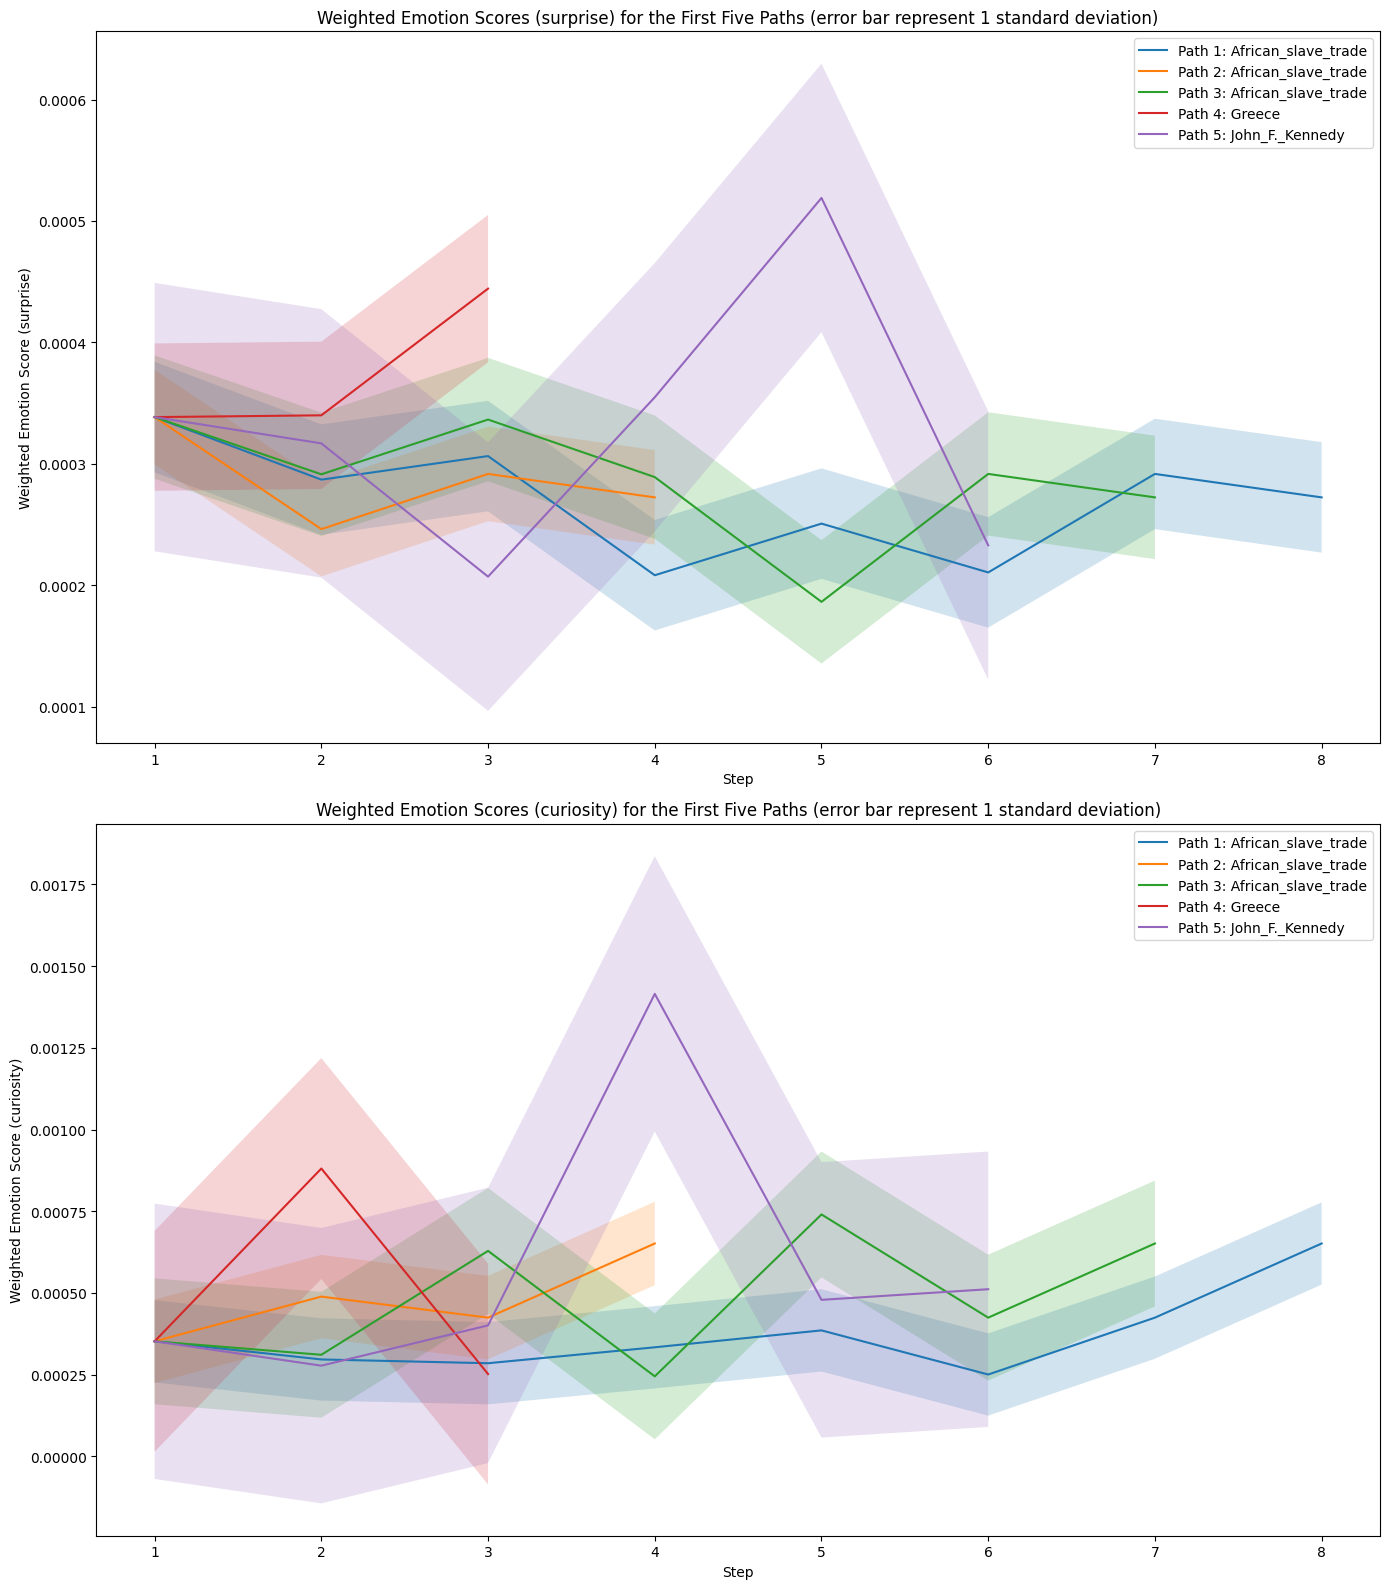

In [13]:
first_five_paths_surprise = backtracking_path_weighted_emotions_surprise_df.head(5)
first_five_paths_curiosity = backtracking_path_weighted_emotions_curiosity_df.head(5)
# Plotting both emotions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 16))

# Plot for Surprise
plot_emotion_paths(ax1, first_five_paths_surprise, 'surprise')

# Plot for Curiosity
plot_emotion_paths(ax2, first_five_paths_curiosity, 'curiosity')

# Show the plots
plt.tight_layout()
plt.show()

### 3.2. Visulization 2 Correlation of Two Emotions

In [14]:
# Create a list to store the correlation results
correlation_data = []

# Iterate over each path and calculate the correlation
for path_index in backtracking_path_weighted_emotions_surprise_df.index:
    correlation, p_value = calculate_emotion_correlation(path_index, backtracking_path_weighted_emotions_surprise_df, backtracking_path_weighted_emotions_curiosity_df)
    num_steps = backtracking_path_weighted_emotions_surprise_df.loc[path_index].drop(labels=['target']).dropna().shape[0]
    
    if correlation is not None:  # Only add rows with valid correlation values
        correlation_data.append({'path_index': path_index, 'correlation': correlation, 'p_value': p_value, 'num_steps': num_steps})

# Convert the list of dictionaries to a DataFrame
correlation_df = pd.DataFrame(correlation_data)

# Calculate the mean and variance of the correlation column
mean_correlation = correlation_df['correlation'].mean()
variance_correlation = correlation_df['correlation'].var()

print("Correlation DataFrame:")
print(correlation_df.head())
print("\nMean Correlation:", mean_correlation)
print("Variance of Correlation:", variance_correlation)

# Print p-values as well
print("\nP-Values:")
print(correlation_df['p_value'].mean())


Correlation DataFrame:
   path_index  correlation   p_value  num_steps
0           0     0.132568  0.754332          8
1           1    -0.651501  0.348499          4
2           2    -0.501131  0.251924          7
3           3    -0.613398  0.579604          3
4           4     0.138638  0.793375          6

Mean Correlation: 0.1349301121490291
Variance of Correlation: 0.3303757638465521

P-Values:
0.517746353919295
